In [38]:
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from utils import *
import time
import matplotlib.pyplot as plt

In [52]:
def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets, _ in data_loader:
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            targets = targets.to(DEVICE).type(torch.LongTensor)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

    
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    n_yz = {(0,0):0, (0,1):0, (1,0):0, (1,1):0}
    
    with torch.no_grad():
        for features, targets, sensitive in data_loader:
            group_boolean_idx = {}
            try:
                features = features.view(-1, NUM_FEATURES).to(DEVICE)
            except:
                print(features)
            targets = targets.to(DEVICE)
            logits, probas = model.forward(features)
            
            predicted_labels = torch.argmax(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
            
            for yz in n_yz:
                group_boolean_idx[yz] = (predicted_labels == yz[0]) & (sensitive == yz[1])
                n_yz[yz] += torch.sum(group_boolean_idx[yz]).item()  
                
        return correct_pred.float()/num_examples * 100, DPDisparity(n_yz)

In [69]:
train_set, test_set, _ = dataGenerate(seed = 95, train_samples = 3000, test_samples = 100)

In [70]:
mean_z = train_set.sen.mean()

In [108]:
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE)

In [117]:
LEARNING_RATE = 0.05
NUM_EPOCHS = 600
PENALTY = 200
NUM_FEATURES = 3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128

In [118]:
# one-sided Fairness Constraint
start_time = time.time()
minibatch_cost = []
epoch_cost = []
model = logReg(num_features=3, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets, sensitive) in enumerate(train_loader):
        features = features.view(-1, NUM_FEATURES).to(DEVICE)
        targets = targets.to(DEVICE).type(torch.LongTensor)
            
        ### FORWARD AND BACK PROP
        probas, logits = model(features)
        cost = zafar_loss(logits, targets, probas, sensitive, PENALTY, mean_z, True)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        
    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    epoch_cost.append(cost)
    
    train_accuracy, train_dp = compute_accuracy(model, train_loader)
    test_accuracy, test_dp = compute_accuracy(model, test_loader)
    
    if (epoch+1) % 20 == 0:
        print('Epoch: %03d/%03d Accuracy: %.4f DP: %.4f Cost: %.4f' % (
                epoch+1, NUM_EPOCHS, train_accuracy, train_dp, cost))
#         print('Train Accuracy: %.3f | Test Accuracy: %.3f' % (train_accuracy, test_accuracy))
#         print('Train DP: %.3f | Test DP: %.3f' % (train_dp, test_dp))
#         print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


Epoch: 020/600 Accuracy: 74.2333 DP: 0.2839 Cost: 0.6932
Epoch: 040/600 Accuracy: 74.6000 DP: 0.2521 Cost: 0.6931
Epoch: 060/600 Accuracy: 75.1000 DP: 0.2394 Cost: 0.6931
Epoch: 080/600 Accuracy: 75.6000 DP: 0.2289 Cost: 0.6931
Epoch: 100/600 Accuracy: 75.6000 DP: 0.2163 Cost: 0.6931
Epoch: 120/600 Accuracy: 75.3667 DP: 0.2060 Cost: 0.6931
Epoch: 140/600 Accuracy: 75.3000 DP: 0.1940 Cost: 0.6931
Epoch: 160/600 Accuracy: 75.3667 DP: 0.1885 Cost: 0.6931
Epoch: 180/600 Accuracy: 75.2667 DP: 0.1791 Cost: 0.6931
Epoch: 200/600 Accuracy: 75.2333 DP: 0.1674 Cost: 0.6931
Epoch: 220/600 Accuracy: 75.1333 DP: 0.1594 Cost: 0.6931
Epoch: 240/600 Accuracy: 75.1667 DP: 0.1542 Cost: 0.6932
Epoch: 260/600 Accuracy: 75.1667 DP: 0.1486 Cost: 0.6932
Epoch: 280/600 Accuracy: 75.1333 DP: 0.1434 Cost: 0.6932
Epoch: 300/600 Accuracy: 74.8667 DP: 0.1381 Cost: 0.6932
Epoch: 320/600 Accuracy: 74.7333 DP: 0.1274 Cost: 0.6932
Epoch: 340/600 Accuracy: 74.7000 DP: 0.1216 Cost: 0.6932
Epoch: 360/600 Accuracy: 74.600

In [99]:
PENALTY = 500
LEARNING_RATE = 0.0001
NUM_EPOCHS = 300

In [100]:
# Fairness Constraint
start_time = time.time()
minibatch_cost = []
epoch_cost = []
model = logReg(num_features=3, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets, sensitive) in enumerate(train_loader):
        features = features.view(-1, NUM_FEATURES).to(DEVICE)
        targets = targets.to(DEVICE).type(torch.LongTensor)
            
        ### FORWARD AND BACK PROP
        probas, logits = model(features)
        
        acc_loss = F.cross_entropy(logits, targets, reduction = 'sum')
        fair_loss0 = torch.mul(sensitive - mean_z, logits.T[0] - torch.mean(logits.T[0]))
        fair_loss0 = torch.mean(torch.mul(fair_loss0, fair_loss0)) 
        fair_loss1 = torch.mul(sensitive - mean_z, logits.T[1] - torch.mean(logits.T[1]))
        fair_loss1 = torch.mean(torch.mul(fair_loss1, fair_loss1)) 
        fair_loss = fair_loss0 + fair_loss1
        cost = acc_loss + PENALTY * fair_loss
        
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        
    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    epoch_cost.append(cost)
    
    train_accuracy, train_dp = compute_accuracy(model, train_loader)
    test_accuracy, test_dp = compute_accuracy(model, test_loader)
    
    if (epoch+1) % 20 == 0:
        print('Epoch: %03d/%03d Accuracy: %.4f DP: %.4f Cost: %.4f' % (
                epoch+1, NUM_EPOCHS, train_accuracy, train_dp, cost))
#         print('Train Accuracy: %.3f | Test Accuracy: %.3f' % (train_accuracy, test_accuracy))
#         print('Train DP: %.3f | Test DP: %.3f' % (train_dp, test_dp))
#         print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


Epoch: 020/300 Accuracy: 53.4667 DP: 0.1815 Cost: 0.6955
Epoch: 040/300 Accuracy: 52.5667 DP: 0.1616 Cost: 0.6983
Epoch: 060/300 Accuracy: 53.8333 DP: 0.1640 Cost: 0.6959
Epoch: 080/300 Accuracy: 55.0333 DP: 0.1652 Cost: 0.6919
Epoch: 100/300 Accuracy: 57.3667 DP: 0.1767 Cost: 0.6878
Epoch: 120/300 Accuracy: 59.6667 DP: 0.1797 Cost: 0.6839
Epoch: 140/300 Accuracy: 61.4667 DP: 0.1750 Cost: 0.6803
Epoch: 160/300 Accuracy: 62.2000 DP: 0.1531 Cost: 0.6769
Epoch: 180/300 Accuracy: 61.9667 DP: 0.1142 Cost: 0.6737
Epoch: 200/300 Accuracy: 61.9667 DP: 0.0634 Cost: 0.6708
Epoch: 220/300 Accuracy: 62.3333 DP: 0.0132 Cost: 0.6680
Epoch: 240/300 Accuracy: 62.0667 DP: 0.0011 Cost: 0.6655
Epoch: 260/300 Accuracy: 62.3333 DP: 0.0055 Cost: 0.6634
Epoch: 280/300 Accuracy: 63.3333 DP: 0.0221 Cost: 0.6616
Epoch: 300/300 Accuracy: 65.1000 DP: 0.0513 Cost: 0.6602
Total Training Time: 1.04 min


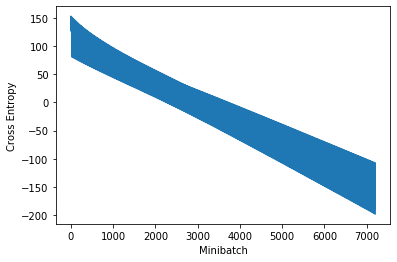

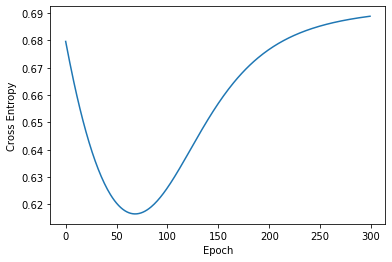

In [45]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()